# Теперь что получилось

In [4]:
import os
from copy import deepcopy

import dgl.nn.pytorch as dglnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from dgl.nn import GATConv, GraphConv
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE
from torch.nn import Linear
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    ChebConv,
    GATConv,
    GCNConv,
    GraphConv,
    NNConv,
    global_mean_pool,
)
from tqdm import tqdm

np.set_printoptions(suppress=True)

Using backend: pytorch


In [5]:
df = pd.read_excel("02-pdbbind-refined.xlsx", engine="openpyxl")

In [6]:
df["e_predict"] = df["e_exp"] * 2 ** (-(df["rmsd"] ** 2) / 4)

In [7]:
df["e_predict"] = df["e_predict"].map(lambda x: abs(x))

In [5]:
folder = "data/"
node_ohe = OHE(categories=[list(range(23)), [0, 1], [0, 1]])
edge_ohe = OHE(categories=[[0, 1]])
graphs = []
for fn in os.listdir(folder):
    if fn.endswith(".npz"):
        data = np.load(folder + fn)
        X = torch.tensor(node_ohe.fit_transform(data["node_data"][:, 1:4]).todense())

        A = edge_ohe.fit_transform(data["edge_data"][:, 1:]).todense()
        E = torch.tensor(np.hstack((data["edge_data"][:, :1], A)))

        g = dgl.graph((data["edges"][:, 0], data["edges"][:, 1]))
        g.ndata["node_features"] = X
        g.edata["edge_features"] = E
        g.y = torch.tensor(
            df[df["name"] == fn.replace(".npz", ".gml")]["e_predict"].item()
        )
        g = dgl.add_self_loop(g)
        graphs.append(g)

In [6]:
dgl.save_graphs(folder + "graphs.bin", graphs)

In [7]:
class GraphDataset(Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph_data = self.graphs[idx]

        graph_data.y_exp = torch.exp(deepcopy(graph_data.y))

        graph_data.y_int = torch.round(deepcopy(graph_data.y_exp)).float()

        return graph_data, graph_data.y

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    graphs,
    [i.y for i in graphs],
    test_size=0.2,
    random_state=42,
    stratify=[np.exp(i.y.cpu().numpy()) > 0.5 for i in graphs],
)

In [10]:
train_dataset = GraphDataset(X_train)
test_dataset = GraphDataset(X_test)

In [11]:
train_dataset[0]

(Graph(num_nodes=517, num_edges=23368,
       ndata_schemes={'node_features': Scheme(shape=(27,), dtype=torch.float64)}
       edata_schemes={'edge_features': Scheme(shape=(3,), dtype=torch.float64)}),
 tensor(0.1591))

In [12]:
from dgl.dataloading import GraphDataLoader

train_loader = GraphDataLoader(
    train_dataset, batch_size=10, drop_last=False, shuffle=True, num_workers=4
)
test_loader = GraphDataLoader(
    test_dataset, batch_size=10, drop_last=False, shuffle=True, num_workers=4
)

In [13]:
for data in train_loader:
    break

## Достаточно простая модель только на фичах нод, rmse ~ 1.9

In [14]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.conv3 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.conv4 = dglnn.GraphConv(hidden_dim, hidden_dim)

        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h.double()))
        h = F.relu(self.conv2(g, h.double()))
        h = F.relu(self.conv3(g, h.double()))
        h = F.relu(self.conv4(g, h.double()))

        with g.local_scope():
            g.ndata["h"] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, "h")

            hg = self.linear1(hg)
            hg = F.relu(hg)
            hg = self.linear2(hg)
            hg = F.relu(hg)

            return self.classify(hg)

In [15]:
model = Classifier(27, 120, 1).double()
print(sum(p.numel() for p in model.parameters()))  # средняя модель
opt = torch.optim.Adam(model.parameters())
device = "cuda:2"
model = model.to(device)

rmse_history = []
for epoch in range(750):
    model.train()
    for batched_graph, labels in train_loader:
        feats = batched_graph.ndata["node_features"].to(device)
        logits = model(batched_graph.to(device), feats)
        loss = F.mse_loss(
            logits.double().view(1, -1), labels.double().view(1, -1).to(device)
        )
        opt.zero_grad()
        loss.backward()
        opt.step()

    preds = []
    trues = []
    model.eval()
    for batched_graph, labels in test_loader:
        feats = batched_graph.ndata["node_features"].to(device)
        logits = model(batched_graph.to(device), feats)
        val_loss = F.mse_loss(
            logits.double().view(1, -1), labels.double().view(1, -1).to(device)
        )
        preds.extend(logits.detach().cpu().numpy())
        trues.extend(labels.detach().cpu().numpy())
    rmse_history.append(mean_squared_error(preds, trues))
    if epoch % 50 == 0:
        print(mean_squared_error(preds, trues))

76081
8.889512553668773
5.2704700980673715
5.385315644960093
4.962996784356028
3.5313531005969168
3.637737494715434
2.3621417175397195
2.249185672085703
2.56945075345658
2.206888341895281
2.5114990437363076
2.691628143323801
1.8139445880272649
2.0032120853308366
1.7040554514679047


In [16]:
min(rmse_history)

1.6802294016394155

In [20]:
rmse_history.index(min(rmse_history))

640

Text(0.5, 1.0, 'Simple GCN node features only')

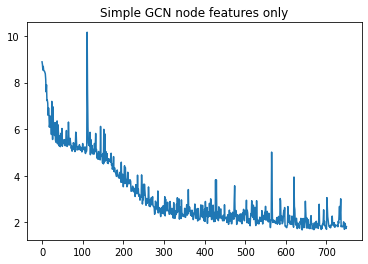

In [22]:
plt.plot(rmse_history)
plt.title("Simple GCN node features only")

# Аналогичная сеть в геометрике

In [23]:
import os
import time
from collections import defaultdict as ddict
from copy import deepcopy

import dgl
import dgl.nn.pytorch as dglnn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from dgl.nn import GATConv, GraphConv
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE
from torch.nn import Linear
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    ChebConv,
    GATConv,
    GCNConv,
    GraphConv,
    NNConv,
    global_mean_pool,
)
from tqdm import tqdm

np.set_printoptions(suppress=True)
from catboost import CatBoostRegressor, Pool

In [24]:
df = pd.read_excel("02-pdbbind-refined.xlsx", engine="openpyxl")

In [25]:
df["e_predict"] = df["e_exp"] * 2 ** (-(df["rmsd"] ** 2) / 4)

In [26]:
df["e_predict"] = df["e_predict"].map(lambda x: abs(x))

In [27]:
df.head()

,pdb,run,pose,nfrb,e_docking,rmsd,eLJ,emetal,eHB,eelec,etors,is_good,e_exp,name,e_predict
0,184l,0,0,2,-5.32687,0.55437,-1.41440,0.0,0.20612,-0.00003,0.2352,1,-6.444844,184l-0-0.gml,6.110599
1,184l,0,1,2,-5.15635,1.80368,-1.34504,0.0,0.26135,-0.00049,0.2352,0,-6.444844,184l-0-1.gml,3.667584
2,184l,0,2,2,-5.03622,4.19935,-1.37091,0.0,0.36299,0.00039,0.2352,0,-6.444844,184l-0-2.gml,0.303446
3,184l,0,3,2,-5.05864,4.24878,-1.40106,0.0,0.37758,0.00002,0.2352,0,-6.444844,184l-0-3.gml,0.282263
4,184l,0,4,2,-5.12396,4.24426,-1.41376,0.0,0.21307,-0.00005,0.2352,0,-6.444844,184l-0-4.gml,0.284147


In [28]:
data = np.load("data/1a28-2-0.npz")

In [29]:
data["node_data"]

array([[460.,   3.,   0.,   0.,   0.],
       [471.,   3.,   0.,   0.,   0.],
       [492.,   0.,   0.,   0.,   0.],
       ...,
       [ 20.,   0.,   1.,   1.,   0.],
       [ 21.,   3.,   1.,   1.,   0.],
       [ 22.,   0.,   1.,   1.,   0.]])

In [8]:
folder = "data/"
node_ohe = OHE(categories=[list(range(23)), [0, 1], [0, 1]])
edge_ohe = OHE(categories=[[0, 1]])
graphs = []
idx_arr = []
y_arr = []

In [9]:
for num, fn in enumerate(os.listdir(folder)):
    if fn.endswith(".npz"):
        data = np.load(folder + fn)
        X = torch.tensor(node_ohe.fit_transform(data["node_data"][:, 1:4]).todense())

        A = edge_ohe.fit_transform(data["edge_data"][:, 1:]).todense()
        E = torch.tensor(np.hstack((data["edge_data"][:, :1], A)))

        pg_data = Data(
            edge_index=torch.tensor(data["edges"][:, 0:2]).t().contiguous().long(),
            x=X.float(),
            edge_attr=E.float(),
            y=torch.tensor(
                df[df["name"] == fn.replace(".npz", ".gml")]["e_predict"].item()
            ),
        )

        idx_arr.append(num)
        y_arr.append(df[df["name"] == fn.replace(".npz", ".gml")]["e_predict"].item())

        graphs.append(pg_data)

# Train/test split, Dataset

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    graphs,
    y_arr,
    test_size=0.2,
    random_state=42,
    stratify=[np.exp(i.y.cpu().numpy()) > 0.5 for i in graphs],
)

In [12]:
class GraphDataset(Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph_data = self.graphs[idx]

        graph_data.y_exp = torch.exp(deepcopy(graph_data.y))

        graph_data.y_int = torch.round(deepcopy(graph_data.y_exp)).float()

        return graph_data

In [13]:
train_dataset = GraphDataset(X_train)
test_dataset = GraphDataset(X_test)

In [14]:
train_dataset[0]

Data(x=[517, 27], edge_index=[2, 22851], edge_attr=[22851, 3], y=0.15911602973937988, y_exp=1.1724740266799927, y_int=1.0)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=6)

In [20]:
def baseline_model(train_dataset, test_dataset):
    criterion = nn.MSELoss(reduction="mean")

    prediction = np.mean([i.y.item() for i in train_dataset])

    true_labels = [i.y.item() for i in test_dataset]
    pred_labels = [prediction for i in range(len(test_dataset))]

    return (
        mean_squared_error(pred_labels, true_labels, squared=False),
        r2_score(pred_labels, true_labels),
        criterion(torch.tensor(pred_labels), torch.tensor(true_labels)).item(),
    )

In [21]:
baseline_model(train_dataset, test_dataset)

(2.926429621304172, -4.3424589920815715e+31, 8.563990328446478)

Бейзлайн модель при текущем сплите отрабатывает на 8.564 RMSE

## Простая графовая регрессионная модель pytorch_geometric без использования edge_features

In [40]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GraphConv, NNConv, global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, node_feature_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(node_feature_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, 1)

    def forward(self, data):
        # 1. Obtain node embeddings
        x, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch,
        )
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()

        return self.lin3(x)


model = GCN(hidden_channels=120, node_feature_channels=train_dataset.num_node_features)
print(model)
print(sum(p.numel() for p in model.parameters()))  # Не очень тяжелая модель

GCN(
  (conv1): GraphConv(27, 120)
  (conv2): GraphConv(120, 120)
  (conv3): GraphConv(120, 120)
  (conv4): GraphConv(120, 120)
  (lin1): Linear(in_features=120, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=120, bias=True)
  (lin3): Linear(in_features=120, out_features=1, bias=True)
)
122521


In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
device = "cuda:2"
model = model.to(device)


def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out.view(-1, 1), data.y.view(-1, 1))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    with torch.no_grad():
        true = []
        preds = []
        for data in test_loader:  # Iterate in batches over the training dataset.
            data = data.to(device)
            out = model(data)  # Perform a single forward pass.
            val_loss = criterion(
                out.view(-1, 1), data.y.view(-1, 1)
            )  # Compute the loss.
            true.extend(data.y.detach().cpu().numpy())
            preds.extend(out.detach().cpu().numpy())

    return mean_squared_error(true, preds)


rmse_history = []
for epoch in range(750):
    rmse_val = train()
    rmse_history.append(rmse_val)
    if epoch % 50 == 0:
        print(rmse_val)

1074.6941
6.8254657
5.5678577
5.309845
3.2959845
2.8815024
3.314702
3.0075715
2.7820928
3.053943
3.1770666
2.538394
2.3291054
2.5020354
2.342524


In [42]:
min(rmse_history)

2.1792986

In [43]:
rmse_history.index(min(rmse_history))

682

(0.0, 14.0)

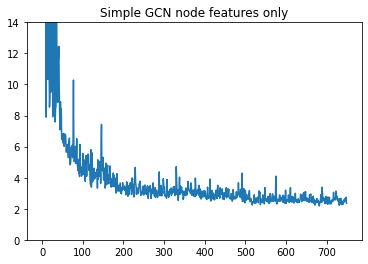

In [48]:
plt.plot(rmse_history)
plt.title("Simple GCN node features only")
plt.ylim([0, 14])